<div align="center">

---
# Decision Trees - ID3 [Artificial Intelligence Project]
---
</div>

<div align="center">

***
## Problem Presentation
***
</div>
    
> ADD PROBLEM PRESENTATION

<div align="center">

***
## ID3 Algorithm 
***
</div>

A well-known decision tree approach for Machine Learning is the Iterative Dichotomiser 3 (ID3) algorithm. By choosing the best characteristic at each node to partition the data depending on information gain, it recursively constructs a tree. The goal is to make the final subsets as homogeneous as possible. By choosing features that offer the greatest reduction in entropy or uncertainty, ID3 iteratively grows the tree. The procedure keeps going until a halting requirement is satisfied, like a minimum subset size or a maximum tree depth. 

The ID3 Algorithm is specifically designed for building decision trees from a given dataset. It's primary objective is to construct a tree that best explains the relationship between attributes in the data and their corresponding class labels.

**1. Selecting the Best Attribute:**
- ID3 employs the concept of entropy and information gain to determine the attribute that best separates the data. Entropy measures the impurity or randomness in the dataset.
- The algorithm calculates the entropy of each attribute and selects the one that results in the most significant information gain when used for splitting the data.

**2. Creating Tree Nodes:**
- The chosen attribute is used to split the dataset into subsets based on its distinct values.
- For each subset, ID3 recurses to find the next best attribute to further partition the data, forming branches and new nodes accordingly.

**3. Stopping Criteria:**
- The recursion continues until one of the stopping criteria is met, such as when all instances in a branch belong to the same class or when all attributes have been used for splitting.

**4. Handling Missing Values:**
- ID3 can handle missing values to prevent overfitting. While not directly included in ID3, post-processing techniques or variations like C4.5 incorporate pruning to improve the tree's generalization.

<div align="center">

***
## Mathematical Concepts of ID3 Algorithm
***
</div>

### Entropy

**Entropy** is a measure of disorder or uncertainty in a set of data. It is a tool used in ID3 to measure a dataset's disorder  or impurity. By dividing the data into as homogeneous subsets as feasible, the objective is to minimze entropy.

For a set $S$ with classes $\{c_1,\space c_2,\space ...\space,\space c_n \}$, the entropy is calculated as:

$$H(S) = \sum_{i=1}^n \space p_i \space log_2(p_i)$$

Where $p_i$ is the proportion of instances of class $c_i$ in the set.

### Information Gain

Information Gain measures how well a certain quality reduces uncertainty. ID3 splits the data at each stage, choosing the property that maximizes Information Gain. It is computes using the distinction between entropy prior to and following the split.

Information Gain measures the effectiveness of an Attribute $A$ in reducing uncertainty in set $S$

$$IG(A,S) = H(S) - \sum_{v \space \in \space values(A)} \frac{|S_v|}{|S|} \cdot H(S_v))$$

Where, $|S_v|$ is the size of the subset of $S$ for which attribute $A$ has value $v$.

### Gain Ratio (Used more in the C4.5 Algorithm)

Gain Ratio is an improvement on Information Gain that considers the inherent worth of characteristics that have a wide range of possible values. It deals with the bias of Information Gan in favor of characteristics with more pronounced values.

$$ GR(A,S) = \frac{IG(A,S)}{\sum_{v\space\in\space values(A)} \frac{|S_v|}{|S|} \cdot log_2(\frac{|S_v|}{|S|})} $$

<div align="center">

***
## Problem's Resolution Approach
***
</div>

In order to properly develop this Project, we decided to separate it into **multiple classes**:

- **Node**:
  - Structural Data Structure used inside the ID3's algorithm.
- **Decision Tree**:
  - Class that focuses on the implementation of the ID3's Algorithm.
- **Dataset**:
  - Responsible to preprocess any given dataset. This helps to properly **format / encode the data** which is going to be later fed to the algorithm.

<div align="center">

***
## Importing Dependencies
***
</div>

In [27]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

# Importing Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ID3 import (Node, DecisionTree)
from DataPreprocessing import (Dataset)
from DataVisualization import (visualize_tree)

pd.options.display.max_columns = None
np.random.seed(1234)

<div align="center">

***
## Decision Tree - ID3 [Class]
***
</div>

> MAYBE ADD TEXT

<div align="center">

***
## Dataset [Class]
***
</div>

> MAYBE ADD TEXT

<div align="center">

***
## Model Evaluation upon the Datasets
***
</div>

In [2]:
rest = Dataset(file_path='./Datasets/restaurant.csv')
x_train, x_test, y_train, y_test = rest.train_test_split(test_size=0.3)
x_train

array([[0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 0],
       [1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 1],
       [0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 0],
       [1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0],
       [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0],
       [1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 0]])

In [3]:
y_train

array([0, 0, 0, 0, 1, 1, 1, 1], dtype=int64)

In [4]:
x_test

array([[1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0],
       [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1],
       [0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0],
       [1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 0]])

In [5]:
y_test

array([0, 0, 1, 1], dtype=int64)

___
### Restaurant Dataset
___

In [6]:
restaurant = Dataset(file_path='./Datasets/restaurant.csv')
print(restaurant.df.shape, "\n")
restaurant.encoded_df.head()

(12, 11) 



,Rain_No,Rain_Yes,Bar_No,Bar_Yes,Type_No,Type_Yes,Est_No,Est_Yes,Res_Full,Res_Some,Alt_$,Alt_$$,Alt_$$$,Price_No,Price_Yes,Fri_No,Fri_Yes,Pat_Burger,Pat_French,Pat_Italian,Pat_Thai,Hun_0-10,Hun_10-30,Hun_30-60,Hun_>60,Class
1,0,1,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0
4,0,1,1,0,0,1,1,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,0
6,1,0,0,1,1,0,1,0,0,0,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0
8,1,0,0,1,0,1,1,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0
9,0,1,0,1,0,1,0,1,1,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0


In [7]:
# restaurant.data
# restaurant.target
# restaurant.features_decoders
# restaurant.cols

In [8]:
restaurant.Estimate_Holdout()

0.5

In [9]:
restaurant.K_Fold_CV(3, DecisionTree)

0.6666666666666666

In [10]:
(X_Train, X_Test, y_Train, y_Test) = restaurant.train_test_split(test_size=0.3)

In [11]:
dt = DecisionTree()
dt.fit(X_Train, y_Train)
restaurant.print_tree(dt)

'Est_No' ? [IG: 54.879%]
 left: 'Alt_$$$' ? [IG: 32.193%]
  left: [Class]: Yes
  right: 'Res_Full' ? [IG: 100.000%]
    left: [Class]: Yes
    right: [Class]: No
 right: [Class]: No


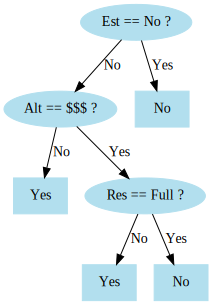

In [12]:
visualize_tree(dt, restaurant)

___
### Weather Dataset
___

In [13]:
weather = Dataset(file_path='./Datasets/weather.csv')
print(weather.df.shape, "\n")
weather.df.head()

(14, 5) 



,Weather,Temp,Humidity,Windy,Play
0,sunny,85,85,False,no
1,sunny,80,90,True,no
2,overcast,83,86,False,yes
3,rainy,70,96,False,yes
4,rainy,68,80,False,yes


In [14]:
weather.encoded_df.head()

,Temp,Humidity,Windy,Weather_overcast,Weather_rainy,Weather_sunny,Play
0,85,85,False,0,0,1,0
1,80,90,True,0,0,1,0
5,65,70,True,0,1,0,0
7,72,95,False,0,0,1,0
13,71,91,True,0,1,0,0


In [15]:
# weather.data
# weather.target
# weather.y_decoder
# weather.cols

In [16]:
weather.Estimate_Holdout()

0.6

In [17]:
weather.K_Fold_CV(3, DecisionTree)

0.4166666666666667

In [18]:
(X_Train, X_Test, y_Train, y_Test) = weather.train_test_split(test_size=0.3)
dt = DecisionTree()
dt.fit(X_Train, y_Train)
weather.print_tree(dt)

'Humidity' ? [IG: 37.888%]
 left: [Play]: yes
 right: 'Weather_sunny' ? [IG: 41.997%]
  left: 'Windy' ? [IG: 25.163%]
    left: [Play]: yes
    right: 'Weather_rainy' ? [IG: 100.000%]
        left: [Play]: yes
        right: [Play]: no
  right: [Play]: no


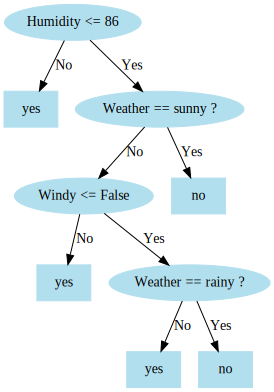

In [19]:
visualize_tree(dt, weather)

___
### Iris Dataset
___

In [20]:
iris = Dataset(file_path='./Datasets/iris.csv')
print(iris.df.shape, "\n")
iris.df.head()

(150, 5) 



,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [21]:
iris.encoded_df.head()

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,0
27,5.2,3.5,1.5,0.2,0
28,5.2,3.4,1.4,0.2,0
29,4.7,3.2,1.6,0.2,0
30,4.8,3.1,1.6,0.2,0


In [22]:
# iris.data
# iris.target
# iris.y_decoder
# iris.cols

In [23]:
iris.Estimate_Holdout()

0.9111111111111111

In [24]:
iris.K_Fold_CV(10, DecisionTree)

0.9400000000000001

In [25]:
(X_Train, X_Test, y_Train, y_Test) = iris.train_test_split(test_size=0.3)
dt = DecisionTree()
dt.fit(X_Train, y_Train)
iris.print_tree(dt)

'petalwidth' ? [IG: 91.830%]
 left: [class]: Iris-setosa
 right: 'petalwidth' ? [IG: 78.369%]
  left: 'sepalwidth' ? [IG: 12.229%]
    left: 'petalwidth' ? [IG: 51.780%]
        left: [class]: Iris-versicolor
        right: 'sepallength' ? [IG: 81.128%]
                left: [class]: Iris-virginica
                right: [class]: Iris-versicolor
    right: [class]: Iris-versicolor
  right: [class]: Iris-virginica


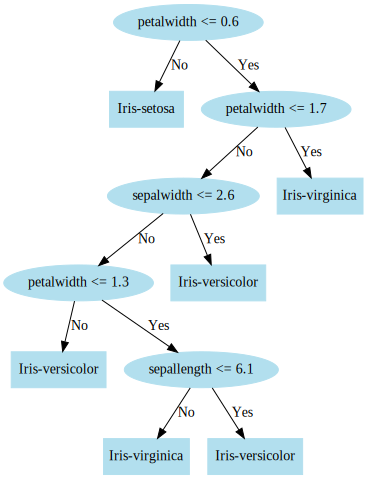

In [26]:
visualize_tree(dt, iris)

___
### Connect-Four Dataset 
___

In [30]:
C4 = Dataset(file_path='./Datasets/connect4.csv')
print(C4.df.shape, "\n")
C4.df.head()

(67557, 43) 



,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,WIN
0,b,b,b,b,b,b,b,b,b,b,b,b,x,o,b,b,b,b,x,o,x,o,x,o,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,win
1,b,b,b,b,b,b,b,b,b,b,b,b,x,b,b,b,b,b,x,o,x,o,x,o,o,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,win
2,b,b,b,b,b,b,o,b,b,b,b,b,x,b,b,b,b,b,x,o,x,o,x,o,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,win
3,b,b,b,b,b,b,b,b,b,b,b,b,x,b,b,b,b,b,x,o,x,o,x,o,b,b,b,b,b,b,o,b,b,b,b,b,b,b,b,b,b,b,win
4,o,b,b,b,b,b,b,b,b,b,b,b,x,b,b,b,b,b,x,o,x,o,x,o,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,win


In [31]:
C4.encoded_df.head()

,X2_b,X2_o,X2_x,X8_b,X8_o,X8_x,X19_b,X19_o,X19_x,X17_b,X17_o,X17_x,X21_b,X21_o,X21_x,X23_b,X23_o,X23_x,X25_b,X25_o,X25_x,X29_b,X29_o,X29_x,X3_b,X3_o,X3_x,X30_b,X30_o,X30_x,X24_b,X24_o,X24_x,X11_b,X11_o,X11_x,X36_b,X36_o,X36_x,X28_b,X28_o,X28_x,X33_b,X33_o,X33_x,X35_b,X35_o,X35_x,X15_b,X15_o,X15_x,X27_b,X27_o,X27_x,X7_b,X7_o,X7_x,X20_b,X20_o,X20_x,X34_b,X34_o,X34_x,X42_b,X42_o,X42_x,X31_b,X31_o,X31_x,X37_b,X37_o,X37_x,X5_b,X5_o,X5_x,X26_b,X26_o,X26_x,X9_b,X9_o,X9_x,X10_b,X10_o,X10_x,X41_b,X41_o,X41_x,X22_b,X22_o,X22_x,X6_b,X6_o,X6_x,X39_b,X39_o,X39_x,X40_b,X40_o,X40_x,X32_b,X32_o,X32_x,X38_b,X38_o,X38_x,X12_b,X12_o,X12_x,X16_b,X16_o,X16_x,X14_b,X14_o,X14_x,X4_b,X4_o,X4_x,X1_b,X1_o,X1_x,X13_b,X13_o,X13_x,X18_b,X18_o,X18_x,WIN
67556,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0
15787,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0
15788,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0
55981,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0
55978,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0


In [32]:
# C4.data
# C4.target
# C4.features_decoders
# C4.cols

In [33]:
C4.Estimate_Holdout()

0.7587329780935465

In [ ]:
(X_Train, X_Test, y_Train, y_Test) = C4.train_test_split(test_size=0.3)
dt = DecisionTree()
dt.fit(X_Train, y_Train)
C4.print_tree(dt)

---

<div align="center">

***
## Just for Guidance [REMOVE LATER]
***
</div>

In [36]:
from sklearn import (datasets)
from sklearn.model_selection import (train_test_split)
from sklearn.metrics import (accuracy_score)
from sklearn.tree import (DecisionTreeClassifier)

In [37]:
def accuracy(y_test, y_pred):
    return sum(y_test == y_pred) / len(y_test)

In [38]:
res =  Dataset(file_path='./Datasets/restaurant.csv')

X = res.data
y = res.target

x_train, x_test, y_train, y_test = train_test_split(X, y)

dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

y_pred = dt.predict(x_test)
print("Accuracy:", accuracy(y_test, y_pred))

Accuracy: 1.0


In [39]:
res =  Dataset(file_path='./Datasets/weather.csv')

X = res.data
y = res.target

x_train, x_test, y_train, y_test = train_test_split(X, y)

dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

y_pred = dt.predict(x_test)
print("Accuracy:", accuracy(y_test, y_pred))

Accuracy: 0.5


In [40]:
res =  Dataset(file_path='./Datasets/iris.csv')

X = res.data
y = res.target

x_train, x_test, y_train, y_test = train_test_split(X, y)

dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

y_pred = dt.predict(x_test)
print("Accuracy:", accuracy(y_test, y_pred))

Accuracy: 0.8947368421052632


In [41]:
res =  Dataset(file_path='./Datasets/connect4.csv')

X = res.data
y = res.target

x_train, x_test, y_train, y_test = train_test_split(X, y)

dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)


y_pred = dt.predict(x_test)
print("Accuracy:", accuracy(y_test, y_pred))

Accuracy: 0.7687388987566608


In [42]:
# Então o Problema não é do Algorithmo mas do split
dt2 = DecisionTree()
dt2.fit(x_train, y_train)
y_pred = dt2.predict(x_test)
print("Accuracy:", accuracy(y_test, y_pred))

Accuracy: 0.7672587329780935


<div align="center">

***
## Advantages and Disadvantages of ID3
***
</div>

### __Advantages__

- **Interpretability**: Decision Trees generated by ID3 are **easily interpretable**, making them usefull for explaining decisions to non-technical stakeholders
- **Handles Categorical Data**: ID3 can effectively **handle categorical attributes** without explicit data preprocessing steps
- **Not Computationally Expensive**: The Algorithm is relatively straightforward and **computationally less expensive** compared to some complex models

### __Disadvantages__

- **Overfitting**: ID3 tends to create complex trees that may **overfit over the training data**, impacting its performance upon new unseen information
- **Sensitive to Noise**: Noise or outliers in the data can lead to the **creation of non-optimal or incorrect splits**
- **Exclusive to Binary Trees**: ID3 only constructs **binary trees** which **limits** its ability to **express more complex relationships** within the data


<div align="center">

***
## Conclusion
***
</div>

The **ID3 Algorithm** laid the groundwork for **decision tree learning**, providing a robust framework for understanding **attribute selection** and **recursive partitioning**. Despite its limitations, ID3's simplicity and interpretability have paved the way for more sophisticated algorithms that address its drawbacks while retaining its essence.

As **Machine Learning** continues to evolve, the ID3 Algorithm remains a **crucial piece** in the mosaic of tree-based methods, serving as a stepping stone for developing **more advanced and accurate models** in the quest for **efficient data analysis and pattern recognition**.


<div align="center">

***
## Bibliographic References
***
</div>

1. Geeks For Geeks (2023). *Decision Tree Algorithms*. Available [here](https://www.geeksforgeeks.org/decision-tree-algorithms/#id3-iterative-dichotomiser-3)
2. Geeks For Geeks (2024). *Iteratice Dichotomiser 3 (ID3) Algorithm From Scratch*. Available [here](https://www.geeksforgeeks.org/iterative-dichotomiser-3-id3-algorithm-from-scratch/)

___
## Video Presentation (YouTube Video)

Moreover, you can find the **Video** for our **Project's Presentation [here](https://youtu.be/dQw4w9WgXcQ?si=NfwpqDkOwLRY6tRQ)**
___
## Final Considerations

$\quad$ If there is any difficulty on downloading or executing this project, please contact us via:

- **Email**:
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@up.pt`
    - [Maximino Canhola](https://github.com/MaximinoCanhola) &#8594; `up201909805@up.pt`
    - [Nuno Gomes](https://github.com/NightF0x26) &#8594; `up202206195@up.pt`